In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

dir_path = './data/{}'
msf_path = 'msf.csv'
dsf_path = 'dsf.csv'

start_year = 1995
end_year = 2022

# Estimating Beta from CAPM

## 0. Data processing

In [2]:
def read_crsp(data_path):
    crsp_df = pd.read_csv(data_path, 
                          usecols=['PERMNO', 'date', 'HSICCD', 'RET', 'vwretd'],
                          dtype={'HSICCD': str, 'RET': str}).rename(columns={'vwretd': 'MKT'})\
    .sort_values(by=['date'])\
    .reset_index(drop=True)

    crsp_df['date'] = pd.to_datetime(crsp_df['date'])
    
    crsp_df['HSICCD'].fillna('0', inplace=True)
    crsp_df['HSICCD'].replace(['Z'], '0', inplace=True)
    crsp_df['HSICCD'] = crsp_df['HSICCD'].apply(lambda val: 
                                              'Agriculture, Forestry and Fishing' if (1 <= int(val) and int(val) <= 999) else 
                                              'Mining' if (1000 <= int(val) and int(val) <= 1499) else 
                                              'Construction' if (1500 <= int(val) and int(val) <= 1799) else 
                                              'Manufacturing' if (2000 <= int(val) and int(val) <= 3999) else 
                                              'Transportation and other Utilities' if (4000 <= int(val) and int(val) <= 4999) else 
                                              'Wholesale Trade' if (5000 <= int(val) and int(val) <= 5199) else
                                              'Retail Trade' if (5200 <= int(val) and int(val) <= 5999) else 
                                              'Finance, Insurance and Real Estate' if (6000 <= int(val) and int(val) <= 6799) else 
                                              'Services' if (7000 <= int(val) and int(val) <= 8999) else 
                                              'Public Administration' if (9000 <= int(val) and int(val) <= 9999) else 
                                              'Other'
                                              )
    
    crsp_df['RET'].replace(['B', 'C'], np.nan, inplace=True)
    crsp_df['RET'] = crsp_df['RET'].astype('float64')

    crsp_df.dropna(subset=['RET', 'MKT'], inplace=True)
    
    crsp_df.info()
    return crsp_df

In [3]:
def build_model(df):
    ret = df['RET']
    df = df.drop(columns=['RET'])
    df = sm.add_constant(df)
    model = sm.OLS(ret, df).fit()
    return model

In [4]:
def init_beta_df(lags):
    beta_df = pd.DataFrame(columns=['PERMNO', 'HSICCD', 'year', 'mkt'])
    for lag in lags:
        beta_df[f'mkt_{lag}'] = None
    beta_df['stat_error'] = None
    return beta_df

def init_comp_beta_df(lags, permno, hsiccd):
    beta_df = init_beta_df(lags)
    beta_df['year'] = range(start_year, end_year + 1)
    beta_df['PERMNO'] = permno
    beta_df['HSICCD'] = hsiccd
    return beta_df

def add_lagged_mkt(comp_df, lags):
    for lag in lags:
        helper = pd.DataFrame()
        helper['date'] = comp_df.apply(lambda row: row['date'] + pd.DateOffset(months=lag), axis=1)
        helper[f'MKT_{lag}'] = comp_df['MKT']
        comp_df = comp_df.merge(helper, how='left', on='date')
    comp_df.fillna(0, inplace=True)
    return comp_df

def get_betas(df, lags):
    beta_df = init_beta_df(lags)
    df_by_comp = df.groupby(['PERMNO'])
    
    for comp_no, comp_df in df_by_comp:
        beta_comp_df = init_comp_beta_df(lags, comp_no[0], comp_df.iloc[0].at['HSICCD'])
        comp_df = add_lagged_mkt(comp_df.drop(columns=['HSICCD']), lags)
        
        for cur_year in range(start_year, end_year + 1):
            cur_comp_df = comp_df[comp_df['date'].dt.year == cur_year]
            if len(cur_comp_df) == 0:
                continue
            
            model = build_model(cur_comp_df[['RET', 'MKT']])
            beta_comp_df.at[cur_year - start_year, 'mkt'] = model.params['MKT']
            beta_comp_df.at[cur_year - start_year, 'stat_error'] = model.get_robustcov_results(cov_type='HAC', maxlags=5).bse[1]
            for lag in lags:
                model = build_model(cur_comp_df[['RET', f'MKT_{lag}']])
                beta_comp_df.at[cur_year - start_year, f'mkt_{lag}'] = model.params[f'MKT_{lag}']

        beta_df = pd.concat([beta_df, beta_comp_df])

    beta_df.dropna(inplace=True)
    for col in ['PERMNO', 'year']:
        beta_df[col] = beta_df[col].astype('int64')
    beta_df['mkt'] = beta_df['mkt'].astype('float64')
    for lag in lags:
        beta_df[f'mkt_{lag}'] = beta_df[f'mkt_{lag}'].astype('float64')
    return beta_df.reset_index(drop=True)

## 1. DSF models

In [5]:
daily_lags = [1, 3, 6, 12, 24]

In [6]:
dsf_df = read_crsp(dir_path.format(dsf_path))
dsf_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 8401489 entries, 0 to 8439705
Data columns (total 5 columns):
 #   Column  Dtype         
---  ------  -----         
 0   PERMNO  int64         
 1   date    datetime64[ns]
 2   HSICCD  object        
 3   RET     float64       
 4   MKT     float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 384.6+ MB


,PERMNO,date,HSICCD,RET,MKT
0,10026,2019-01-02,Manufacturing,-0.024829,0.001796
1,12672,2019-01-02,"Finance, Insurance and Real Estate",-0.001029,0.001796
2,17482,2019-01-02,"Finance, Insurance and Real Estate",0.001683,0.001796
3,87842,2019-01-02,"Finance, Insurance and Real Estate",0.014856,0.001796
4,92885,2019-01-02,"Finance, Insurance and Real Estate",-0.002932,0.001796


In [8]:
dsf_beta_df = get_betas(dsf_df, daily_lags)

In [9]:
dsf_beta_df.head()

,PERMNO,HSICCD,year,mkt,mkt_1,mkt_3,mkt_6,mkt_12,mkt_24,stat_error
0,10026,Manufacturing,2019,0.310169,0.154313,-0.083758,0.452063,0.000000,0.000000,0.089057
1,10026,Manufacturing,2020,1.232666,-0.233682,0.015970,-0.024652,-0.140391,0.000000,0.096026
2,10026,Manufacturing,2021,0.599956,0.019149,0.210269,0.142449,0.048080,-0.027472,0.11684
3,10026,Manufacturing,2022,0.358293,-0.149583,0.092329,0.311951,0.013568,0.021302,0.063235
4,12672,"Finance, Insurance and Real Estate",2019,0.217108,-0.007398,0.009763,-0.019455,0.000000,0.000000,0.02346


## 2. MSF models

In [10]:
monthly_lags = [12, 24, 36]

In [11]:
msf_df = read_crsp(dir_path.format(msf_path))
msf_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 397121 entries, 0 to 408351
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   PERMNO  397121 non-null  int64         
 1   date    397121 non-null  datetime64[ns]
 2   HSICCD  397121 non-null  object        
 3   RET     397121 non-null  float64       
 4   MKT     397121 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 18.2+ MB


,PERMNO,date,HSICCD,RET,MKT
0,10026,2019-01-31,Manufacturing,0.067501,0.088294
1,16744,2019-01-31,"Finance, Insurance and Real Estate",0.381865,0.088294
2,16745,2019-01-31,"Finance, Insurance and Real Estate",0.284896,0.088294
3,16746,2019-01-31,"Finance, Insurance and Real Estate",0.105187,0.088294
4,16747,2019-01-31,"Finance, Insurance and Real Estate",0.050294,0.088294


In [13]:
msf_beta_df = get_betas(msf_df, monthly_lags)

## 3. Welch (2021)

In [14]:
def remove_outliers(crsp_df):
    df_copy = crsp_df.copy()
    df_copy.loc[:, 'RET'] = df_copy.apply(lambda row: 
                                          row['MKT'] * (-2) if row['RET'] < row['MKT'] * (-2) else
                                          row['MKT'] * 4 if row['RET'] > row['MKT'] * 4 else
                                          row['RET'],
                                          axis=1
                                         )
    return df_copy

In [15]:
adj_dsf_df = remove_outliers(dsf_df)
adj_dsf_beta_df = get_betas(adj_dsf_df, daily_lags)

In [16]:
adj_msf_df = remove_outliers(msf_df)
adj_msf_beta_df = get_betas(adj_msf_df, monthly_lags)

## 4. Descriptive stats

In [17]:
all_beta_dfs = {'Beta for daily data': dsf_beta_df, 
                'Beta for monthly data': msf_beta_df,
                'Beta for adjusted daily data': adj_dsf_beta_df, 
                'Beta for adjusted monthly data': adj_msf_beta_df}
all_beta_df_names = list(all_beta_dfs.keys())

In [18]:
def print_stats(df):
    print(df.describe())
    print('\nSkewness')
    print(df.skew())
    print('\nKurtosis')
    print(df.kurt())
    print('\nQuantiles')
    print(df.quantile([.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))

In [19]:
for df_name, beta_df in all_beta_dfs.items():
    print(df_name, end='\n\n')
    print_stats(beta_df.drop(columns=['PERMNO', 'HSICCD','year']))
    print('\n\n')

Beta for daily data

             mkt      mkt_1      mkt_3      mkt_6     mkt_12     mkt_24
count  17.000000  17.000000  17.000000  17.000000  17.000000  17.000000
mean    0.451700  -0.035274   0.036518   0.060397   0.002423  -0.011968
std     0.515157   0.094092   0.090897   0.159983   0.067973   0.051517
min    -0.056779  -0.233682  -0.083758  -0.194729  -0.140840  -0.188832
25%     0.061459  -0.062600   0.001268  -0.024652   0.000000   0.000000
50%     0.217108  -0.009786   0.014233   0.001267   0.000000   0.000000
75%     0.701136   0.010857   0.057996   0.139747   0.034434   0.000000
max     1.501411   0.154313   0.268442   0.452063   0.109488   0.049085

Skewness
mkt           0.942378
mkt_1        -0.361546
mkt_3         1.280507
mkt_6         1.064133
mkt_12       -0.906007
mkt_24       -2.753328
stat_error     0.52231
dtype: object

Kurtosis
mkt          -0.572221
mkt_1         0.518469
mkt_3         2.066934
mkt_6         1.106914
mkt_12        0.958937
mkt_24        9.31004

## 5. Correlations

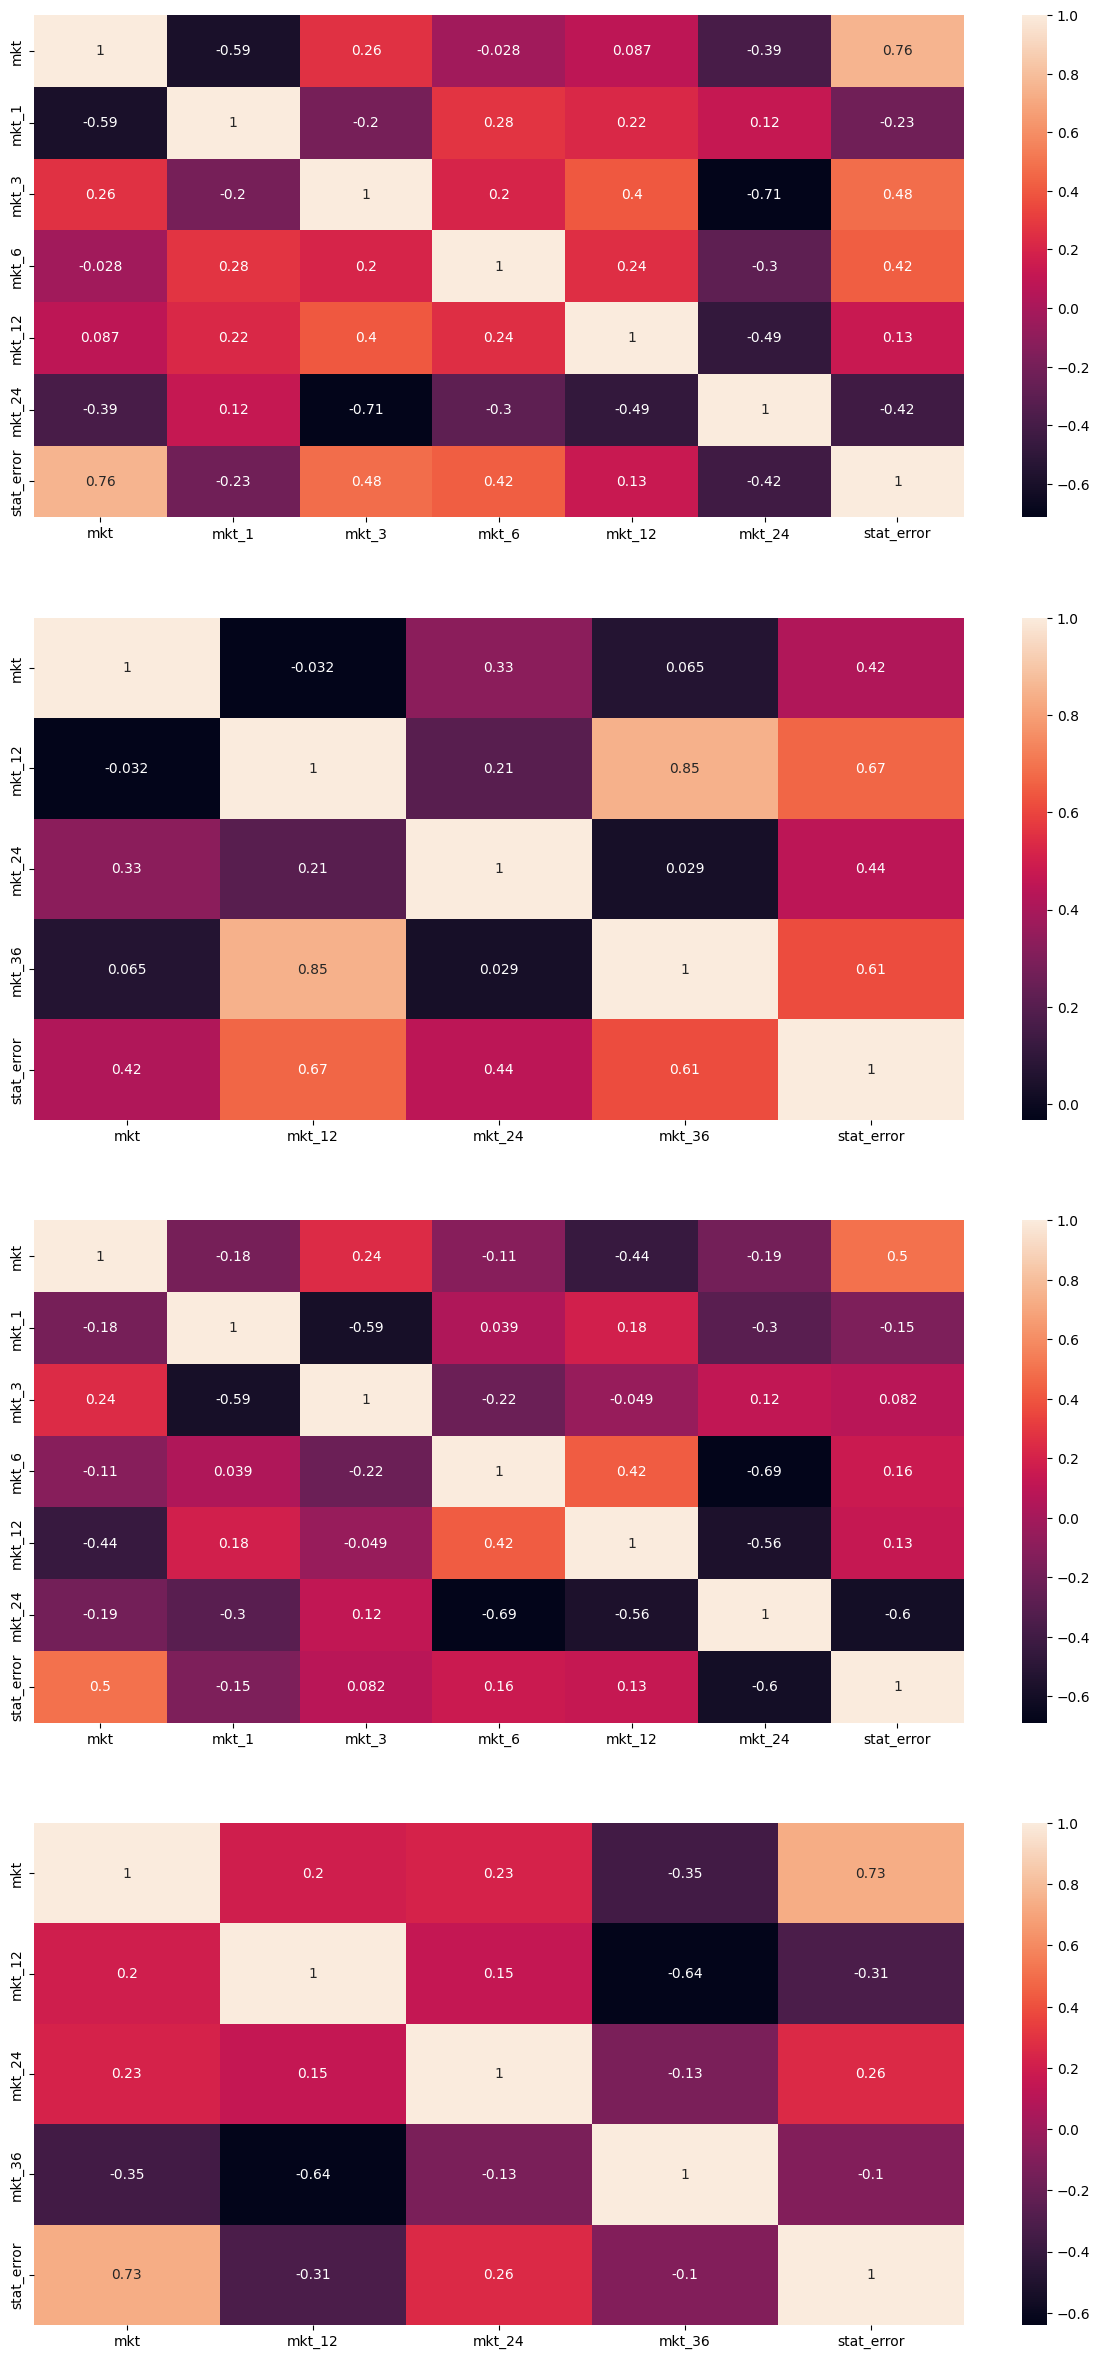

In [20]:
fig, axs = plt.subplots(len(all_beta_df_names), 1, figsize=(15, 30))
for i in range(len(all_beta_df_names)):
    sns.heatmap(all_beta_dfs[all_beta_df_names[i]].drop(columns=['PERMNO', 'HSICCD','year']).corr(), ax=axs[i], annot=True)

## 6. Plot by industry

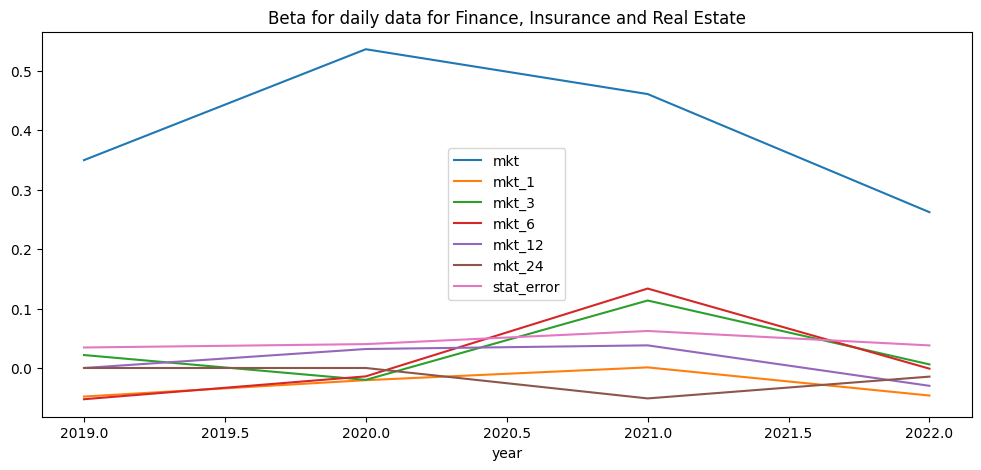

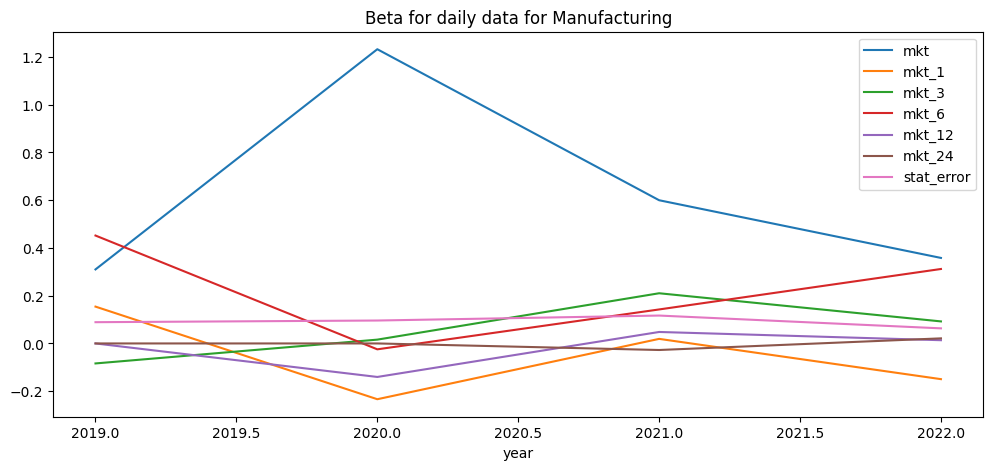

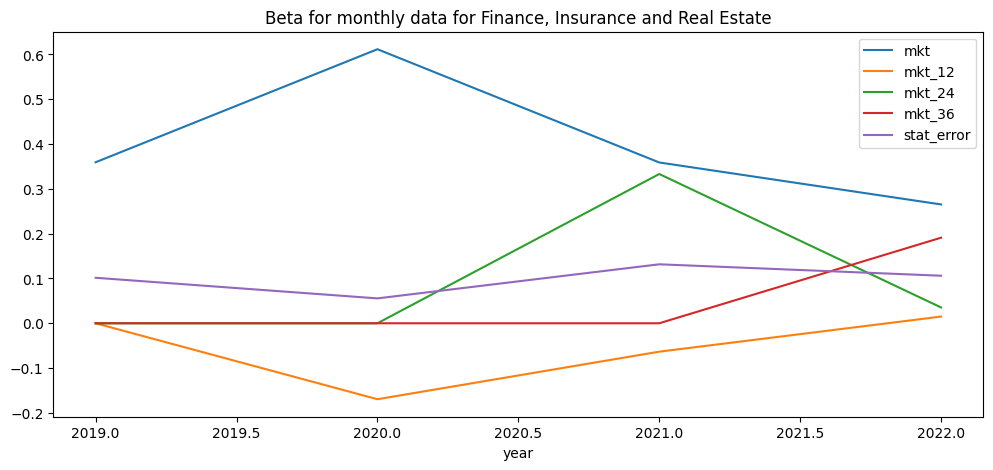

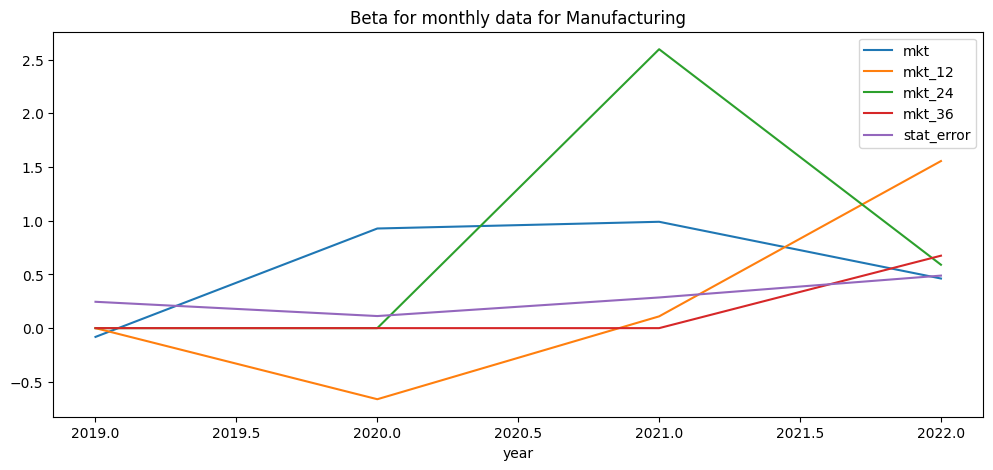

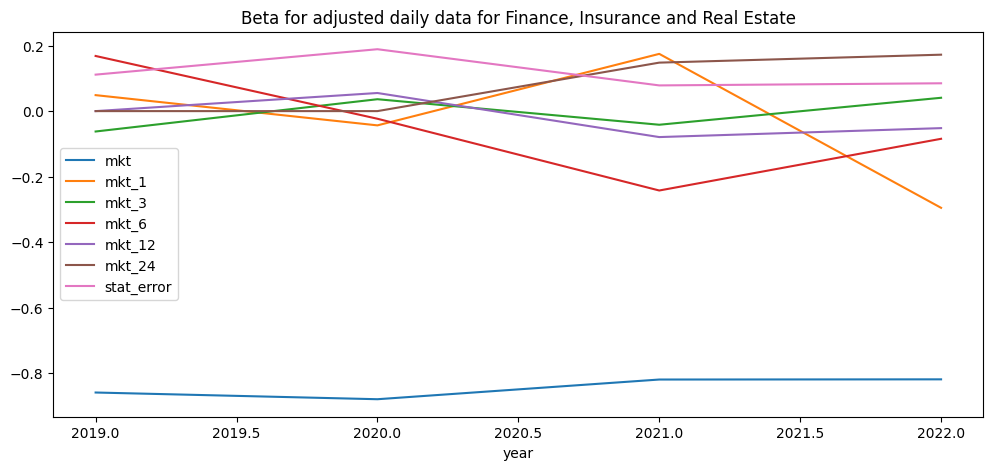

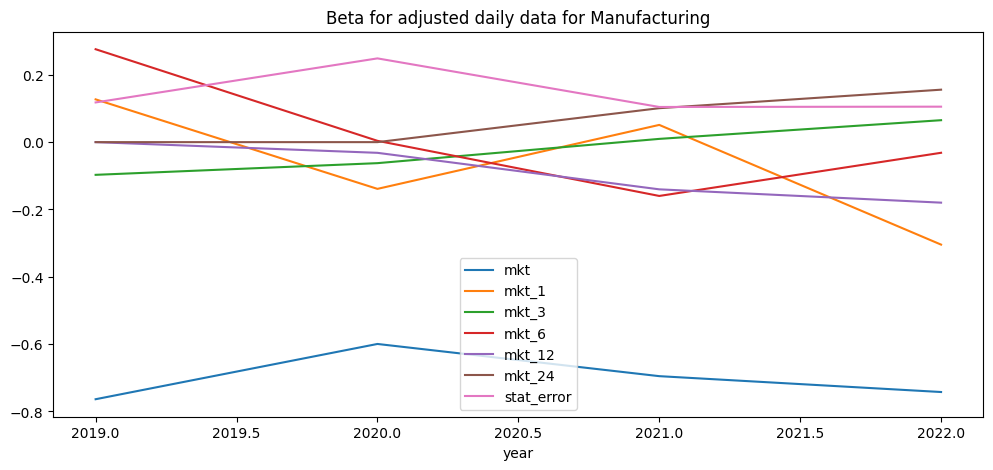

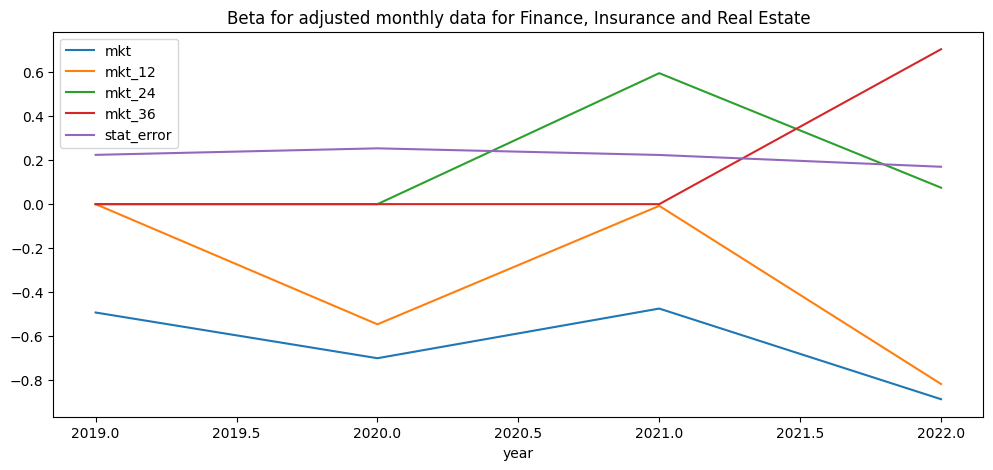

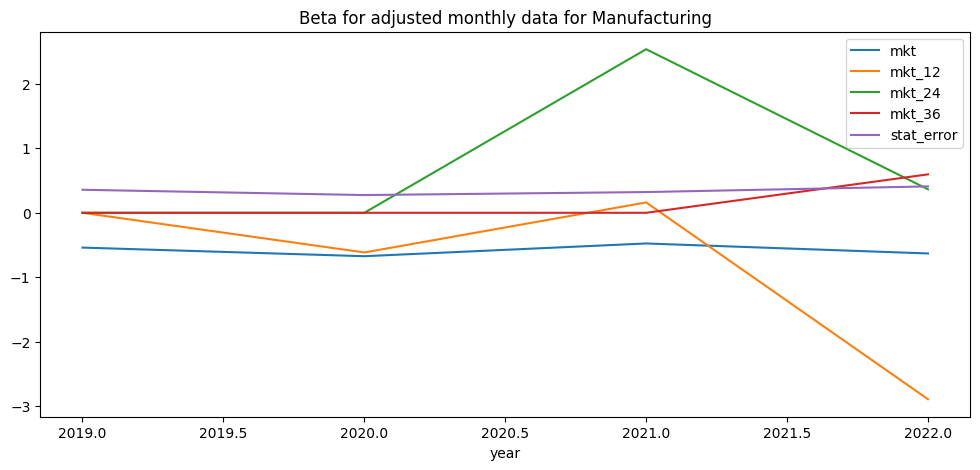

In [21]:
for i in range(len(all_beta_df_names)):
    beta_df_by_industry = all_beta_dfs[all_beta_df_names[i]].drop(columns=['PERMNO']).groupby(['HSICCD'])
    for industry_name, beta_industry_df in beta_df_by_industry:
        beta_industry_df_by_year = beta_industry_df.drop(columns=['HSICCD']).groupby(['year']).mean()
        beta_industry_df_by_year.plot(figsize=(12, 5))
        plt.legend()
        plt.title(f'{all_beta_df_names[i]} for {industry_name[0]}')

## 7. Conclusions

As we can see on the demo dataset, most of the coefficients are insignificant in comparison with the one for market portfolio return. However, to make better analysis it is crucial to provide this analysis for the entire data.

## CAPM, Beta and Stock Returns

Due to the higher overall significance of current market porfolio return, the current market portfolio return betas is chosen.

In [22]:
for df_name, beta_df in all_beta_dfs.items():
    beta_df['deciles'] = pd.qcut(beta_df['mkt'], q=10)
    beta_df.sort_values(by=['deciles'], inplace=True)
    beta_df.reset_index(drop=True, inplace=True)

In [23]:
for df_name, beta_df in all_beta_dfs.items():
    beta_df_by_deciles = beta_df[['mkt', 'stat_error', 'deciles']].groupby(['deciles'], observed=True).mean()
    # print(beta_df_by_deciles.iloc[-1].at['mkt'])
    print(f'For {df_name}:')
    print(f'\t* the difference between high-beta and low-beta portfolios is equal to ', 
          f'{beta_df_by_deciles.iloc[-1].at["mkt"] - beta_df_by_deciles.iloc[0].at["mkt"]}.')
    mkt_mean = beta_df_by_deciles['mkt'].mean()
    error_mean = beta_df_by_deciles['stat_error'].mean()
    t_stat = mkt_mean / error_mean
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), 10))
    print(F'\t* the t-statistics valuea and p-value are equal to {t_stat} and {p_value} respectively.')
    print('\n\n')

For Beta for daily data:
	* the difference between high-beta and low-beta portfolios is equal to  1.4070689347939116.
	* the t-statistics valuea and p-value are equal to 7.952148822676897 and 1.2409765097753933e-05 respectively.



For Beta for monthly data:
	* the difference between high-beta and low-beta portfolios is equal to  1.4692630430211737.
	* the t-statistics valuea and p-value are equal to 3.132457235355399 and 0.010645892519265399 respectively.



For Beta for adjusted daily data:
	* the difference between high-beta and low-beta portfolios is equal to  0.6551266483932618.
	* the t-statistics valuea and p-value are equal to -6.35614369705049 and 8.286030183257687e-05 respectively.



For Beta for adjusted monthly data:
	* the difference between high-beta and low-beta portfolios is equal to  1.0572752173269608.
	* the t-statistics valuea and p-value are equal to -2.5548229065141976 and 0.028626213464072903 respectively.



As we can see, p-value is rather small for monthly data and extremely small for daily data, i.e., the null hypothesis is rejected, i.e., betas are not equal to zero with respect to Newey-West t-statistics. But analysis on the entire dataset is required.